# Quantum Black Holes - Light Deflection
Suzanne Parr, Group 4

The research goal is to understand how quantum corrections affect the deflection angle, $\hat{\alpha}$, as light is deflected by a black hole. We assume the observer, source, and black hole all lie in the equatorial plane ($\theta = \frac{\pi}{2}$). For light, $\epsilon = 0$ where epsilon is the "constant of motion". At $r = r_0$, the closest approach to the black hole, $\frac{dr}{d\phi} = 0$ and also $\frac{dr}{d\lambda} = 0$. Therefore the radial equation,

$$\left( \frac{dr}{d\lambda} \right)^2 = \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right)$$

at $r = r_0$ becomes, $\frac{E^2}{L^2} = \frac{f(r_0)}{h(r_0)}$. Therefore if we set L = 3.8 and $r_0 = 3.9$ we can solve for E for each value of $Q_b$ and, if we have the same initial $t, r, \phi$, we can plot superimposed trajectories to visually and numerically compare $\hat{\alpha}$. Substituting $\frac{E^2}{L^2}$ in the expression for $\frac{dr}{d\phi}$ we get,

$$\frac{dr}{d\phi} = \frac{1}{ \sqrt{ \frac{h(r)}{g(r)} \left( \frac{h(r)}{h(r_0)} \cdot \frac{f(r_0)}{f(r)} - 1 \right) } }$$

We can integrate to get the effective deflection angle, $\hat{\alpha}$:

$$\hat{\alpha}(r_0) = 2 \int_{r_0}^{\infty} dr \, \frac{1}{ \sqrt{ \frac{h(r)}{g(r)} \left( \frac{h(r)}{h(r_0)} \cdot \frac{f(r_0)}{f(r)} - 1 \right) } } - n\pi$$

In [25]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from scipy.integrate import solve_ivp
from scipy.integrate import quad

# Particle Motion in the improved Schwarzschild Metric

To plot trajectories, start with the Point Particle Lagrangian (describes particle motion in a SC spacetime):

$$L = g_{\mu\nu} \dot{x}^\mu \dot{x}^\nu = -f(r)\dot{t}^2 + g(r)\dot{r}^2 + h(r)\left( \dot{\theta}^2 + \sin^2(\theta)\dot{\phi}^2 \right)$$

Spherical symmetry means we can confine motion to the equatorial plane and if we integrate once (with respect to $\theta$), we get 3 components of motion that we can solve to get $r(\phi)$,

$$\frac{dt}{d\lambda} = \frac{E}{f(r)}$$

$$\frac{d\phi}{d\lambda} = \frac{L}{h(r)}$$

$$\left( \frac{dr}{d\lambda} \right)^2 = \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right)$$

In [26]:
# Block 1 - expressions derived from the improved Schwarzschild metric

# schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# improved schwarzschild metric functions (dependent on radial component, r, M, and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(np.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(np.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential (included for completeness)
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

# Assign Values to Constants

Assign values for Mass (M) of the black hole, Angular momentum (L) of the orbiting particle. Angular momentum changes the shape of the effective potential; I picked a value that lead to well-defined trajectories for light deflection. I chose $Q_c = 0$ since its effect is negligable and we can isolate the effect of the $Q_b$ correction.

In [27]:
# Block 2 - assign values for parameters: black hole Mass, particle Angular Momentum (L). 
M1 = 1.0  
rs1 = r_sc(M1)
L1 = 3.8
Q_c0 = 0.0
eps = 0.0

# Plotting Trajectories

Using the function 'solve_geodesics()' we solve for $r(\lambda)$ and $\phi(\lambda)$ by integrating the 3 components of motion with $\lambda$ as the independent variable. This results in a list of values which can be converted to cartesian coordinates: y(x).

In [28]:
# Block 3 - function for inward (and outward if required) integration of components of motion
def solve_geodesic(r_init, phi_init, t_init, lam_range, params, epsilon=0, direction='inward', stop_far_out=True, r_max=60):
    E, L, M, Q_b, Q_c = params
    sign = -1 if direction == 'inward' else 1
    flipped_on_this_neg = False

    # Check squared at the initial radius
    ff0 = float(f(r_init, M, Q_b, Q_c))
    gg0 = float(g(r_init, M, Q_b, Q_c))
    hh0 = float(h(r_init, M, Q_c))

    squared0 = (1/gg0) * (E**2 / ff0 - (epsilon + L**2 / hh0))
    print("Initial squared:", squared0)

    if squared0 < 0:
        print("Warning: Initial region is classically forbidden.")
        flipped_on_this_neg = True

    def dy_dt(lam, y):
        nonlocal sign, flipped_on_this_neg

        t, r, phi = y
        r = float(r)

        ff = float(f(r, M, Q_b, Q_c))
        gg = float(g(r, M, Q_b, Q_c))
        hh = float(h(r, M, Q_c))

        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))

        if squared < 0 and not flipped_on_this_neg:
            sign *= -1
            flipped_on_this_neg = True
        elif squared >= 0:
            flipped_on_this_neg = False

        dt_dlam = E / ff
        dr_dlam = sign * np.sqrt(abs(squared))
        dphi_dlam = L / r**2

        return [dt_dlam, dr_dlam, dphi_dlam]

    def horizon_event(lam, y):
        return y[1] - (2 * M)
    horizon_event.terminal = True
    horizon_event.direction = -1  # detect crossing inward

    events = [horizon_event]

    if stop_far_out:
        def escape_event(lam, y):
            return y[1] - r_max
        escape_event.terminal = True
        escape_event.direction = 1  # detect escaping outward
        events.append(escape_event)

    sol = solve_ivp(
        dy_dt,
        lam_range,
        [t_init, r_init, phi_init],
        t_eval=np.linspace(*lam_range, 2000),
        atol=1e-6,
        rtol=1e-6,
        events=events,
        max_step=0.2
    )

    for i, event in enumerate(sol.t_events):
        if len(event) > 0:
            label = 'horizon' if i == 0 else f'event {i}'
            print(f"{label} triggered at λ = {event[0]:.4f}")

    t_vals = sol.y[0]
    r_vals = sol.y[1]
    phi_vals = np.unwrap(sol.y[2])

    return t_vals, r_vals, phi_vals



# Selecting E values

At the closest approach to the black hole ($r = r_0$), $\frac{dr}{d_\lambda} = 0$ and the radial expression reduces to: 

$$\frac{E^2}{L^2} = \frac{f(r_0)}{h(r_0)}$$

If we set constant values for L and $r_0$ ($L = 3.8, r_0 = 3.9$) we can solve for E for each value of $Q_b$ and put them into an array (E_vals).

In [29]:
# block 4 - select E values 
#------- get E based on a common value for r0 where (E^2 / L^2 = f(r0) / h(r0))
r0 = 3.9 # closest approach
Qb_vals = [0.0, 0.25, 0.5, 0.75, 1.0]

# Compute E for each Qb
E_vals = []

for Qb in Qb_vals:
    f_r0 = float(f(r0, M1, Qb, Q_c0))
    h_r0 = float(h(r0, M1, Q_c0))
    E_sq = L1**2 * f_r0 / h_r0
    E = np.sqrt(E_sq)
    E_vals.append(E)
    print(f"Qb = {Qb:.2f}, E = {E:.6f}")

Qb = 0.00, E = 0.680085
Qb = 0.25, E = 0.688575
Qb = 0.50, E = 0.696985
Qb = 0.75, E = 0.705316
Qb = 1.00, E = 0.713571


## Build Light Deflection datasets ##

Set initial conditions and build data arrays for $r(\lambda)$ and $\phi(\lambda)$ by calling solve_geodesics() for each pair of $Q_b$ and E values. Start integrating inwards from far out at $r = 20\,r_s$. Next superimpose all 5 light trajectories in one plot and include the asymptote which extends backwards past the Lens to where the Image would be. It is also a reference line against which to measure the effective deflection angle, $\hat{\alpha}$.

In [30]:
# ---- Block 5 - create data for light deflection ---- #
# ------- initial conditions ------ #
phi0 = 0.0
t0 = 0.0
lam_range0 = [0, 100] 
r_init = 20 * rs1 

# lists to store results
x_vals_list = []
y_vals_list = []

# loop over all Qb and E values
for Qb, E in zip(Qb_vals, E_vals):
    params = (E, L1, M1, Qb, Q_c0)
    
    # integrate geodesic
    t_vals, r_vals, phi_vals = solve_geodesic(r_init, phi0, t0, lam_range0, params, epsilon=0)
    
    # cartesian coordinates
    x_vals = r_vals * np.cos(phi_vals)
    y_vals = r_vals * np.sin(phi_vals)
    
    x_vals_list.append(x_vals)
    y_vals_list.append(y_vals)

Initial squared: 0.45394247582983527
Initial squared: 0.4654879931346019
Initial squared: 0.4770619843275038
Initial squared: 0.4886636733887056
Initial squared: 0.500292314531978


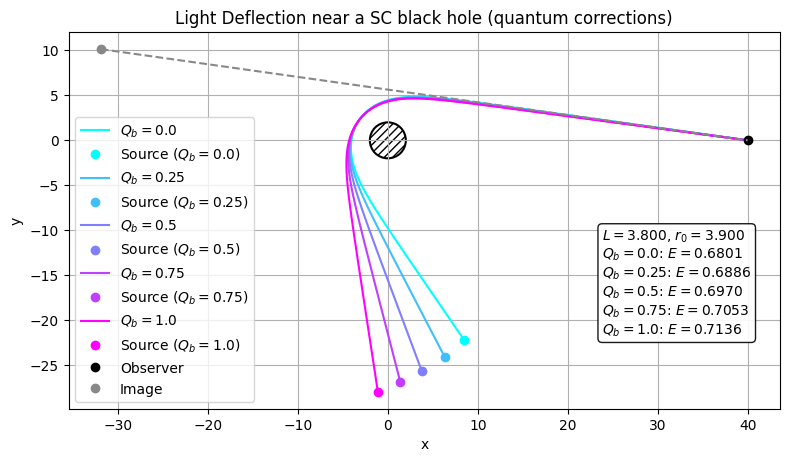

In [31]:
# Block 6 - plot trajectories
# ------ source positions: last point of each trajectory ------
sources = [(x[-1], y[-1]) for x, y in zip(x_vals_list, y_vals_list)]

# ------ incoming asymptote from first trajectory ------
n_backtrace = 50
x_inc = x_vals_list[0][:n_backtrace]
y_inc = y_vals_list[0][:n_backtrace]

# fit a line y = m*x + c to incoming segment (data start)
m, c = np.polyfit(x_inc, y_inc, 1) # degree = 1 for line

# total arc length of the path
dx = np.diff(x_vals_list[0])
dy = np.diff(y_vals_list[0])
segment_len = np.sqrt(dx**2 + dy**2)
arc_length = np.sum(segment_len)

# extend the line backward (asymptote)
x_start = x_vals_list[0][0]
x_end = x_start - arc_length / np.sqrt(1 + m**2)
x_back = np.linspace(x_end, x_start, 100)
y_back = m * x_back + c

colors = [cm.cool(q) for q in Qb_vals]

plt.figure(figsize=(8, 6))

# plot trajectories, source positions
for x, y, src, q_val, color in zip(x_vals_list, y_vals_list, sources, Qb_vals, colors):
    plt.plot(x, y, label=rf"$Q_b = {q_val}$", color=color)
    plt.plot(*src, 'o', color=color, label=rf"Source ($Q_b={q_val}$)")

# observer
plt.plot(40, 0, 'ko', label='Observer')

# lens
lens_radius = 2.0
lens_circle = plt.Circle((0, 0), lens_radius, edgecolor='black',
                         facecolor='none', hatch='////', linewidth=1.5)
plt.gca().add_patch(lens_circle)

# image
image_pos = (x_back[0], y_back[0])
plt.plot(*image_pos, 'o', color='#888888', label="Image")
plt.plot(x_back, y_back, '--', color='#888888')

label_text = (
    rf"$L = {L1:.3f}$, $r_0 = {r0:.3f}$" + "\n"
    rf"$Q_b = 0.0$: $E = {E_vals[0]:.4f}$" + "\n"
    rf"$Q_b = 0.25$: $E = {E_vals[1]:.4f}$" + "\n"
    rf"$Q_b = 0.5$: $E = {E_vals[2]:.4f}$" + "\n"
    rf"$Q_b = 0.75$: $E = {E_vals[3]:.4f}$" + "\n"
    rf"$Q_b = 1.0$: $E = {E_vals[4]:.4f}$"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
plt.text(0.75, 0.48, label_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=props)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Light Deflection near a SC black hole (quantum corrections)')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Effective Deflection Angle $\hat{\alpha}$ ##

The effective deflection angle, $\hat{\alpha}$, quantifies how much a light trajectory is bent as it passes near a black hole. It is computed as the absolute angular difference between the incoming and outgoing asymptotic directions of the trajectory, measured relative to the x-axis.

Since we integrate the light trajectory backward in time (from the observer to the source), the initial segment of the trajectory corresponds to the incoming (inbound) direction, and the final segment corresponds to the outgoing (outbound) direction.

To estimate the asymptotic directions, we extract a short segment (length = n_fit) of the trajectory at the beginning and end, and compute the angle of each segment with respect to the x-axis using:

$$\theta = \arctan2(\Delta y, \Delta x)$$

$\theta_{\text{in}}$ is computed from the first 'n_fit' points (inbound).

$\theta_{\text{out}}$ is computed from the last 'n_fit' points (outbound).

The deflection angle is then given by the smallest angular difference between these directions:

$$\hat{\alpha} = \left| \theta_{\text{out}} - \theta_{\text{in}} \right|$$

If this angle exceeds $\pi$, it is corrected as:

$$\hat{\alpha} = 2 \pi - \left| \theta_{\text{out}} - \theta_{\text{in}} \right|$$

$\hat{\alpha}$ is converted to degrees to plot vs the quantum parameter, $Q_b$.


2.3127946148373804
2.189002018994577
2.065252473233988
1.9588300482143488
1.8561200781774492


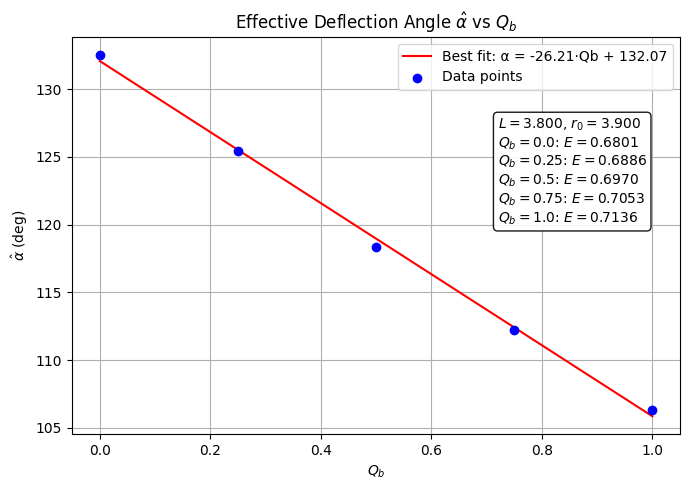

In [32]:
# Block 7 - calculate the deflection angle (alpha)
alpha_vals = []
n_fit = 50  # segment length

# loop over the 5 trajectories (1 for each Qb value)
for x_vals, y_vals in zip(x_vals_list, y_vals_list):
    # fit incoming segment (starting at observer where data begins)
    x_in = x_vals[:n_fit]
    y_in = y_vals[:n_fit]
    # np.arctan2(dy, dx) gives the correct angle to the x-axis for all 4 quadrants
    theta_in = np.arctan2(y_in[-1] - y_in[0], x_in[-1] - x_in[0])

    # fit outgoing segment (starting at source where data ends)
    x_out = x_vals[-n_fit:]
    y_out = y_vals[-n_fit:]
    theta_out = np.arctan2(y_out[-1] - y_out[0], x_out[-1] - x_out[0])

    # computes smallest angle between two direction vectors (i.e. 0 to π)
    delta_theta = np.abs(theta_out - theta_in)
    # constrains the angle between 0 and π to find the 'interior angle'
    if delta_theta > np.pi:
        delta_theta = 2 * np.pi - delta_theta
    print(delta_theta)

    alpha_deg = np.degrees(delta_theta)
    alpha_vals.append(alpha_deg)

# fit a linear model to (Qb_vals, alpha_vals)
fit_coeffs = np.polyfit(Qb_vals, alpha_vals, 1)  # degree 1 = linear
fit_line = np.poly1d(fit_coeffs)
Qb_fit = np.linspace(min(Qb_vals), max(Qb_vals), 200)
alpha_fit = fit_line(Qb_fit)

plt.figure(figsize=(7, 5))
plt.plot(Qb_fit, alpha_fit, color='red', label=f'Best fit: α = {fit_coeffs[0]:.2f}·Qb + {fit_coeffs[1]:.2f}')

# plot data points
plt.scatter(Qb_vals, alpha_vals, color='blue', zorder=5, label='Data points')

plt.xlabel(r"$Q_b$")
plt.ylabel(r"$\hat{\alpha}$ (deg)")
plt.title(r"Effective Deflection Angle $\hat{\alpha}$ vs $Q_b$")
plt.grid(True)

label_text = (
    rf"$L = {L1:.3f}$, $r_0 = {r0:.3f}$" + "\n"
    rf"$Q_b = 0.0$: $E = {E_vals[0]:.4f}$" + "\n"
    rf"$Q_b = 0.25$: $E = {E_vals[1]:.4f}$" + "\n"
    rf"$Q_b = 0.5$: $E = {E_vals[2]:.4f}$" + "\n"
    rf"$Q_b = 0.75$: $E = {E_vals[3]:.4f}$" + "\n"
    rf"$Q_b = 1.0$: $E = {E_vals[4]:.4f}$"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
plt.text(0.70, 0.80, label_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=props)

plt.legend()
plt.tight_layout()
plt.show()